<a href="https://colab.research.google.com/github/mamiruco/kaggle-flight-price-prediction/blob/main/mamiruco-flight-price-prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
%cd /content/drive/My Drive/10_development/machine_learning/flight_price_prediction/

/content/drive/My Drive/10_development/machine_learning/flight_price_prediction


In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [36]:
df = pd.read_csv('./data/Clean_Dataset.csv')
df.head()

,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


# Preprocessing of data and EDA

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        300153 non-null  int64  
 1   airline           300153 non-null  object 
 2   flight            300153 non-null  object 
 3   source_city       300153 non-null  object 
 4   departure_time    300153 non-null  object 
 5   stops             300153 non-null  object 
 6   arrival_time      300153 non-null  object 
 7   destination_city  300153 non-null  object 
 8   class             300153 non-null  object 
 9   duration          300153 non-null  float64
 10  days_left         300153 non-null  int64  
 11  price             300153 non-null  int64  
dtypes: float64(1), int64(3), object(8)
memory usage: 27.5+ MB


In [38]:
def print_df_info(df):
    for column in df.columns:
        unique_count = df[column].nunique()
        unique_values = df[column].unique()
        unique_values_str = str(unique_values)
        unique_values_str_limited = unique_values_str[:100]
        print(f"[{df[column].dtype}] {column} : {unique_count}")
        print(f"{unique_values_str_limited}")
        print("-" * 40)
    return

print_df_info(df)

[int64] Unnamed: 0 : 300153
[     0      1      2 ... 300150 300151 300152]
----------------------------------------
[object] airline : 6
['SpiceJet' 'AirAsia' 'Vistara' 'GO_FIRST' 'Indigo' 'Air_India']
----------------------------------------
[object] flight : 1561
['SG-8709' 'SG-8157' 'I5-764' ... '6E-7127' '6E-7259' 'AI-433']
----------------------------------------
[object] source_city : 6
['Delhi' 'Mumbai' 'Bangalore' 'Kolkata' 'Hyderabad' 'Chennai']
----------------------------------------
[object] departure_time : 6
['Evening' 'Early_Morning' 'Morning' 'Afternoon' 'Night' 'Late_Night']
----------------------------------------
[object] stops : 3
['zero' 'one' 'two_or_more']
----------------------------------------
[object] arrival_time : 6
['Night' 'Morning' 'Early_Morning' 'Afternoon' 'Evening' 'Late_Night']
----------------------------------------
[object] destination_city : 6
['Mumbai' 'Bangalore' 'Kolkata' 'Hyderabad' 'Chennai' 'Delhi']
---------------------------------------

In [39]:
df=df.drop('Unnamed: 0',axis=1)

In [40]:
df=df.drop('flight', axis=1)

In [41]:
df.describe()

,duration,days_left,price
count,300153.000000,300153.000000,300153.000000
mean,12.221021,26.004751,20889.660523
std,7.191997,13.561004,22697.767366
min,0.830000,1.000000,1105.000000
25%,6.830000,15.000000,4783.000000
50%,11.250000,26.000000,7425.000000
75%,16.170000,38.000000,42521.000000
max,49.830000,49.000000,123071.000000


<Axes: xlabel='airline', ylabel='count'>

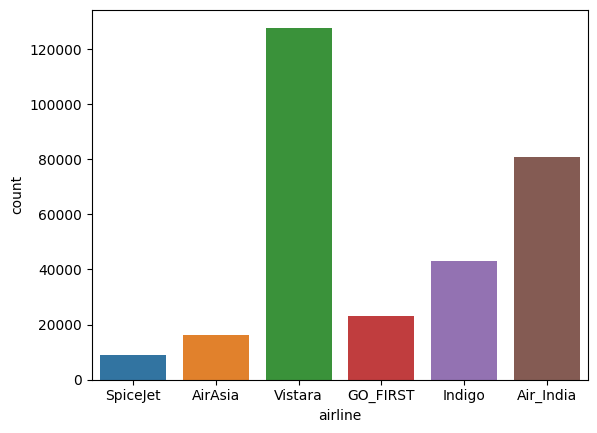

In [42]:
sns.countplot(x='airline',data=df)

<Axes: xlabel='class', ylabel='count'>

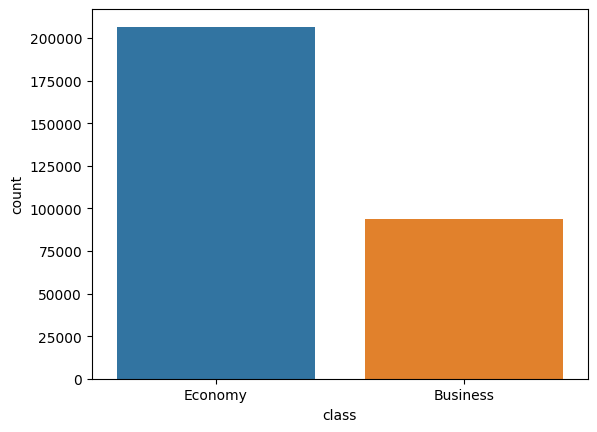

In [43]:
sns.countplot(x='class',data=df)

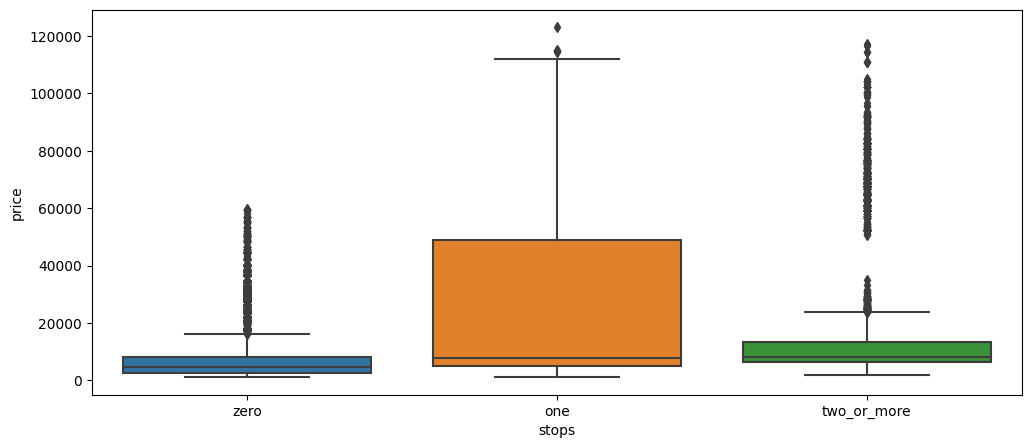

In [44]:
plt.figure(figsize=(12,5))
sns.boxplot(x='stops',y='price',data=df)
plt.show()

In [77]:
plt.figure(figsize=(16, 8))
sns.histplot(data=df, x='price', hue='class', bins=36)

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:917: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  val in data


ValueError: ignored

<Figure size 1600x800 with 0 Axes>

# Performing target encoding for all categorical variables

In [48]:
cat_cols = list(df.select_dtypes(include=['object']).columns)
print(f"Number of categorical columns: {len(cat_cols)}")
print(f"Categorical columns:\n{cat_cols}")

Number of categorical columns: 7
Categorical columns:
['airline', 'source_city', 'departure_time', 'stops', 'arrival_time', 'destination_city', 'class']


[Target encoding for categorical features]

各カテゴリ変数をそれらのターゲット変数の平均値（または中央値）に置き換える方法である。in other words, ターゲット変数を使ってカテゴリ特徴をエンコードする。

Target encodingの利点は、特にカテゴリ特徴が多数の場合、One hot encodingよりも正確な方法でカテゴリ特徴とターゲット変数の間の関係を捕捉できることです。また、Target encodingは特徴空間の次元を小さくすることができる。

Target encodingの欠点は、いくつかのカテゴリについてサンプルが少なすぎる場合、オーバーフィッティングのリスクを持つことである。

In [55]:
#!pip install category_encoders #https://colab.research.google.com/github/tbradshaw91/Predictive-Modeling-Sprint_Challenge/blob/master/Predictive_Modeling_Sprint.ipynb#scrollTo=iQTd1_LXyJe4
import category_encoders as ce

te = ce.TargetEncoder(cols=cat_cols)
df = te.fit_transform(df, df['price'])

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.8/81.8 kB 1.5 MB/s eta 0:00:00


In [56]:
df.head()

,airline,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,6179.278881,18951.326639,21232.361894,9375.938535,21586.758341,21372.529469,6572.342383,2.17,1,5953
1,6179.278881,18951.326639,20370.676718,9375.938535,22231.076098,21372.529469,6572.342383,2.33,1,5953
2,4091.072742,18951.326639,20370.676718,9375.938535,14993.139521,21372.529469,6572.342383,2.17,1,5956
3,30396.536302,18951.326639,21630.760254,9375.938535,18494.598993,21372.529469,6572.342383,2.25,1,5955
4,30396.536302,18951.326639,21630.760254,9375.938535,22231.076098,21372.529469,6572.342383,2.33,1,5955


In [61]:
df.isna().sum()

airline             0
source_city         0
departure_time      0
stops               0
arrival_time        0
destination_city    0
class               0
duration            0
days_left           0
price               0
dtype: int64

In [62]:
# Min Max Scaler: transformation of data
from sklearn.preprocessing import MinMaxScaler
names = df.columns
indexes = df.index
sc = MinMaxScaler((0, 1)) #between 0 and 1 range
df = sc.fit_transform(df)
data_scaled = pd.DataFrame(df, columns=names, index=indexes)
data_scaled.head()

,airline,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,0.079383,0.0,0.867088,0.0,0.876048,0.833363,0.0,0.027347,0.0,0.039749
1,0.079383,0.0,0.804496,0.0,0.930839,0.833363,0.0,0.030612,0.0,0.039749
2,0.000000,0.0,0.804496,0.0,0.315340,0.833363,0.0,0.027347,0.0,0.039773
3,1.000000,0.0,0.896027,0.0,0.613097,0.833363,0.0,0.028980,0.0,0.039765
4,1.000000,0.0,0.896027,0.0,0.930839,0.833363,0.0,0.030612,0.0,0.039765


In [63]:
y = data_scaled['price']
X_data = data_scaled.drop(['price'], axis=1)

# Feature engineering:

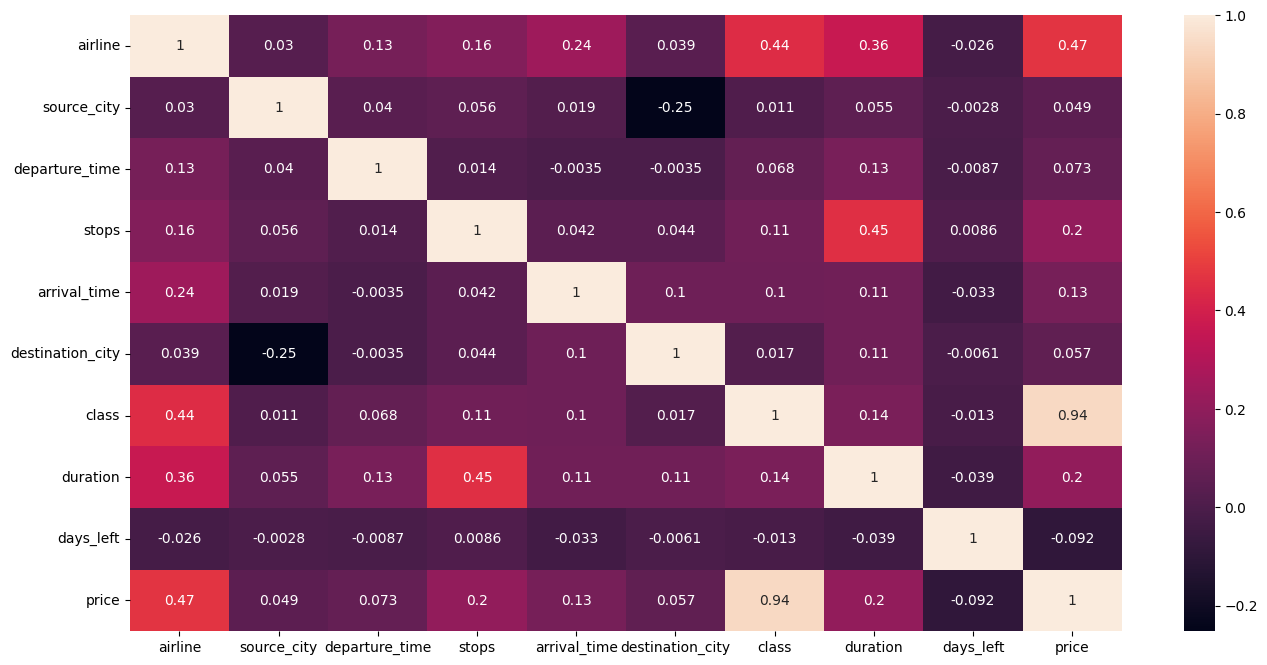

In [66]:
# 1. Pearson Correlation ピアソンの相関
plt.figure(figsize=(16,8))
cor = data_scaled.corr()
sns.heatmap(cor, annot=True)
plt.show()

In [68]:
#Correlation with target variable price
abs(cor["price"])

airline             0.471865
source_city         0.049099
departure_time      0.072732
stops               0.203405
arrival_time        0.128853
destination_city    0.056619
class               0.937860
duration            0.204222
days_left           0.091949
price               1.000000
Name: price, dtype: float64

According to Pearsons correlation, top 4 relevant features are: class, airline, stops and duration.

In [69]:
# 2. Kbest Selection:
from sklearn.feature_selection import SelectKBest, f_classif

selector = SelectKBest(f_classif, k=4)
X_important = selector.fit_transform(X_data, y)

# Get a boolean mask of the selected features
mask = selector.get_support()

# Create a list of the selected feature names
important_feature_names = X_data.columns[mask]

print(important_feature_names)

Index(['airline', 'source_city', 'destination_city', 'class'], dtype='object')


According to Pearsons correlation, top 4 relevant features are: 'airline', 'source_city', 'destination_city', 'class'.

# Building model

モデルの評価指標について

1. score:
テストデータセット上での学習済みモデルの性能を自動で評価する便利な方法を提供する。分類問題の場合、model.scoreは、特定の分類アルゴリズムと評価指標の選択に応じて、accuracy、precision、recallまたはF1などを返す。回帰問題では、model.scoreはR二乗値、平均絶対誤差、平均二乗誤差などを返す。

2. Mean squared error(平均二乗誤差)：
https://aizine.ai/glossary-mse/

3.R-squared(決定係数):

R-squaredは、回帰モデルがデータにどれだけよく適合するかを示す統計的尺度である。これは、dependent variable従属変数（予測しようとする変数）の分散のうち、independent variable(独立変数)（説明変数）（予測を行うために使用する変数）によって説明できる割合を測定する
R-squaredスコアは、0 から 1 の範囲で、スコアが高いほどモデルのデータへの適合がよいことを示す。
R2乗は、さまざまな回帰モデルのパフォーマンスを比較する簡単な方法を提供するので便利である。しかしながら，それはモデルが全体的にデータにどれだけよく適合するかを伝えるだけで，個々の予測の正確さについての情報を提供しない．したがって、モデルの性能をより完全に理解するために、平均2乗誤差のような他の評価指標とともに使われることが多い。

In [70]:
# Split the data into training and testing sets:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_data, y, test_size=0.2, random_state=42)

In [71]:
# Linear Regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


reg = LinearRegression().fit(X_train, y_train)


y_pred_train = reg.predict(X_train)
y_pred_test = reg.predict(X_test)


accuracy_train = reg.score(X_train, y_train)
mse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)


accuracy_test = reg.score(X_test, y_test)
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)


print("Accuracy - Train: {:} Test: {:}".format(accuracy_train, accuracy_test))
print("MSE - Train: {:} Test: {:}".format(mse_train, mse_test))
print("R2 - Train: {:} Test: {:}".format(r2_train, r2_test))

Accuracy - Train: 0.902068821024104 Test: 0.902090866012934
MSE - Train: 0.0033911422062857218 Test: 0.0033928087752166393
R2 - Train: 0.902068821024104 Test: 0.902090866012934


In [72]:
# Decision Tree:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

dt = DecisionTreeRegressor(random_state=42)

dt.fit(X_train, y_train)

# Predict the values for the training and testing sets
y_pred_train = dt.predict(X_train)
y_pred_test = dt.predict(X_test)

# Compute the accuracy, MSE, and R2 for the training set
accuracy_train = dt.score(X_train, y_train)
mse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)

# Compute the accuracy, MSE, and R2 for the testing set
accuracy_test = dt.score(X_test, y_test)
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

print("Accuracy - Train: {:} Test: {:}".format(accuracy_train, accuracy_test))
print("MSE - Train: {:} Test: {:}".format(mse_train, mse_test))
print("R2 - Train: {:} Test: {:}".format(r2_train, r2_test))

Accuracy - Train: 0.9992865963348827 Test: 0.9761391287007689
MSE - Train: 2.4703606187499706e-05 Test: 0.0008268418913708326
R2 - Train: 0.9992865963348827 Test: 0.9761391287007689


In [73]:
# Random Forest:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

rf = RandomForestRegressor(n_estimators=10, random_state=42)

rf.fit(X_train, y_train)

# Predict the values for the training and testing sets
y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)

# Compute the accuracy, MSE, and R2 for the training set
accuracy_train = rf.score(X_train, y_train)
mse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)

# Compute the accuracy, MSE, and R2 for the testing set
accuracy_test = rf.score(X_test, y_test)
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

print("Accuracy - Train: {:} Test: {:}".format(accuracy_train, accuracy_test))
print("MSE - Train: {:} Test: {:}".format(mse_train, mse_test))
print("R2 - Train: {:} Test: {:}".format(r2_train, r2_test))

Accuracy - Train: 0.9968480580428352 Test: 0.9839044759652212
MSE - Train: 0.00010914484553826688 Test: 0.000557752203120513
R2 - Train: 0.9968480580428352 Test: 0.9839044759652212


In [74]:
# XGBoost:
import xgboost as xgb

XGB = xgb.XGBRegressor(objective ='reg:squarederror', n_estimators = 10, seed = 42)

XGB.fit(X_train, y_train)


y_pred_train = XGB.predict(X_train)
y_pred_test = XGB.predict(X_test)


accuracy_train = XGB.score(X_train, y_train)
mse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)


accuracy_test = XGB.score(X_test, y_test)
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

print("Accuracy - Train: {:} Test: {:}".format(accuracy_train, accuracy_test))
print("MSE - Train: {:} Test: {:}".format(mse_train, mse_test))
print("R2 - Train: {:} Test: {:}".format(r2_train, r2_test))

Accuracy - Train: 0.9554380467122173 Test: 0.9543006169195679
MSE - Train: 0.001543082827849209 Test: 0.0015836037111487365
R2 - Train: 0.9554380467122173 Test: 0.9543006169195679


In [75]:
#AdaBoost:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score


abr = AdaBoostRegressor(n_estimators=50, learning_rate=0.1, random_state=42)
abr.fit(X_train, y_train)


y_pred_train = abr.predict(X_train)
y_pred_test = abr.predict(X_test)

accuracy_train = abr.score(X_train, y_train)
mse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)


accuracy_test = abr.score(X_test, y_test)
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

print("Accuracy - Train: {:} Test: {:}".format(accuracy_train, accuracy_test))
print("MSE - Train: {:} Test: {:}".format(mse_train, mse_test))
print("R2 - Train: {:} Test: {:}".format(r2_train, r2_test))

Accuracy - Train: 0.9355549541637678 Test: 0.934653662723564
MSE - Train: 0.0022315907681970757 Test: 0.0022644223016929778
R2 - Train: 0.9355549541637678 Test: 0.934653662723564
